In [109]:
from __future__ import division
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as pl
import statsmodels.api as sm

import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
# Add file
MTA_Fare = np.load('MTA_Fare.npy')
MTA_Fare.astype(float)
MTA = np.ndarray.flatten(MTA_Fare)
MTA = MTA.astype(float)
MTA[MTA==-1] = NaN
MTA = np.reshape(MTA,(600, 23, 194))
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [65]:
# Create time range: 194 weeks from 05/21/2010 to 02/21/2014
date = pd.date_range(start='20100521',end='20140221',freq='1W-FRI')[1:195]

In [101]:
# Create data frames: time series per station and time series per ridership type

print (MTA.shape)
#for all stations
mta_stations = np.transpose(np.nansum(MTA, axis=0))
print (mta_stations.shape)
mta_stations = pd.DataFrame(mta_stations,index=date,columns=ridetype).dropna()
#for all ride types
mta_rides = np.transpose(np.nansum(MTA, axis=1))
print (mta_rides.shape)
mta_rides = pd.DataFrame(mta_rides,index=date).dropna()
len(mta_rides)

(600L, 23L, 194L)
(194L, 23L)
(194L, 600L)


194

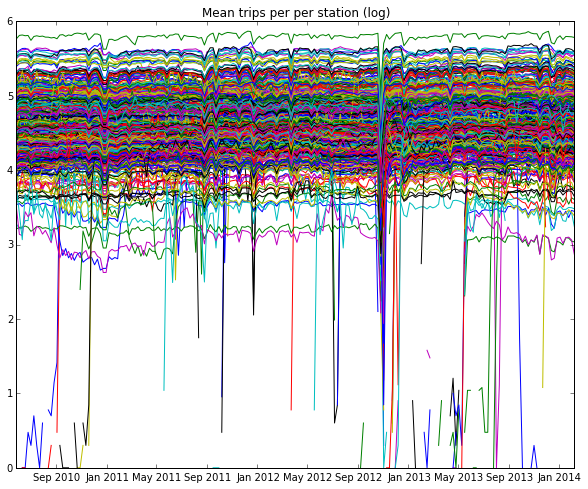

In [68]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(date,log10(mta_rides))
ax.set_title("Mean trips per per station (log)")

In [69]:
# Make barplot of means for each type of subscription
#barplot(ridetype,np.nanmean(MTA,axis=0))
MTA.shape

(600L, 23L, 194L)

In [70]:
mta_sta_norm=mta_stations
for col in mta_stations:
    mta_sta_norm[col] = (mta_stations[col] - np.nanmean(mta_stations[col]))/np.nanstd(mta_stations[col])

In [71]:
mta_rides_norm=mta_rides
for col in mta_rides:
    mta_rides_norm[col] = (mta_rides[col] - np.nanmean(mta_rides[col]))/np.nanstd(mta_rides[col])

##Task 1: 
###Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it and figure out what it is due to.

In this section I plot the unique average time series accross all variables (ridership type and station), i.e. the mean number of trips per station per ridership type, each week. If this time series is standardized, it is easy to see that there is one big outlier below -3 standard deviations.

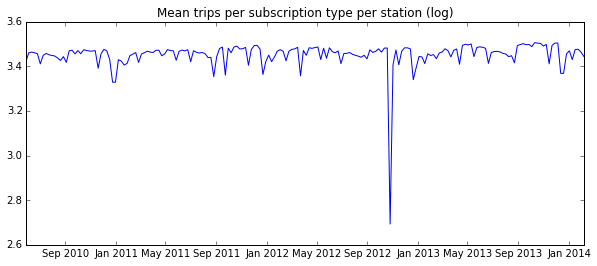

In [74]:
# Plotting the average time series for all stations and all ridership types

mta_mean = np.nanmean(np.nanmean(MTA,axis=1),axis=0)
#plt.plot(date,log10(mta_mean))
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(date,log10(mta_mean))
ax.set_title("Mean trips per subscription type per station (log)")

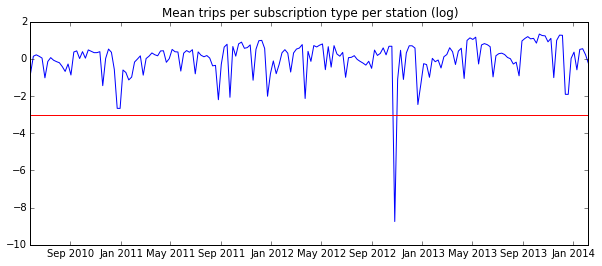

In [75]:
# Visually, it helps to identify the outliers from the normalized curve

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(date,(mta_mean - mta_mean.mean())/mta_mean.std())
ax.set_title("Mean trips per subscription type per station (log)")
plt.axhline(y=-3, xmin=0, xmax=1,c='r')

Now that it has been visually identified that the outlier happened somewhere between September of 2012 and January of 2013, it could be easily identified in the time series.

In [76]:
# Calculate thresholds

thresholds = [np.nanmean(mta_mean) - 3*np.nanstd(mta_mean),
 np.nanmean(mta_mean) + 3*np.nanstd(mta_mean)]
print(thresholds)
ind_thres = (mta_mean<thresholds[0]) | (mta_mean>thresholds[1])
print( "The peak week started in ", date[ind_thres])

[2040.9079118966463, 3656.2460921413867]
The peak week started in  DatetimeIndex(['2012-10-26'], dtype='datetime64[ns]', freq='W-FRI', tz=None)


Sandy hit New York City in October the 29th, that is the event we are seeing here.

#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

First, let us do a visual inspection

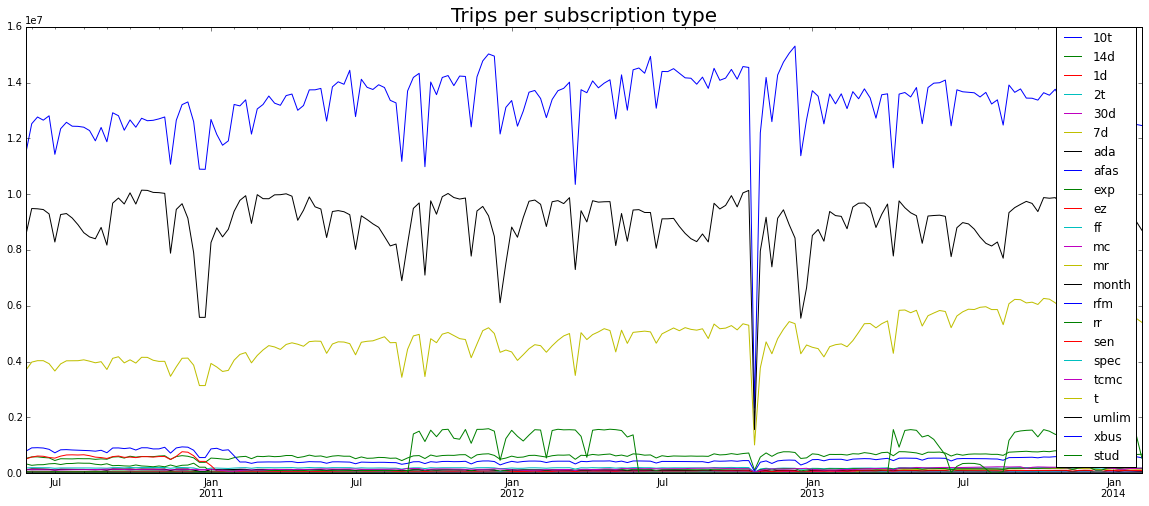

In [103]:
# Plotting trips per subscription type

ax = mta_stations.plot(figsize=(20,8))
ax.set_title("Trips per subscription type", fontsize=20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000B864C080>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000D8FB3EB8>], dtype=object)

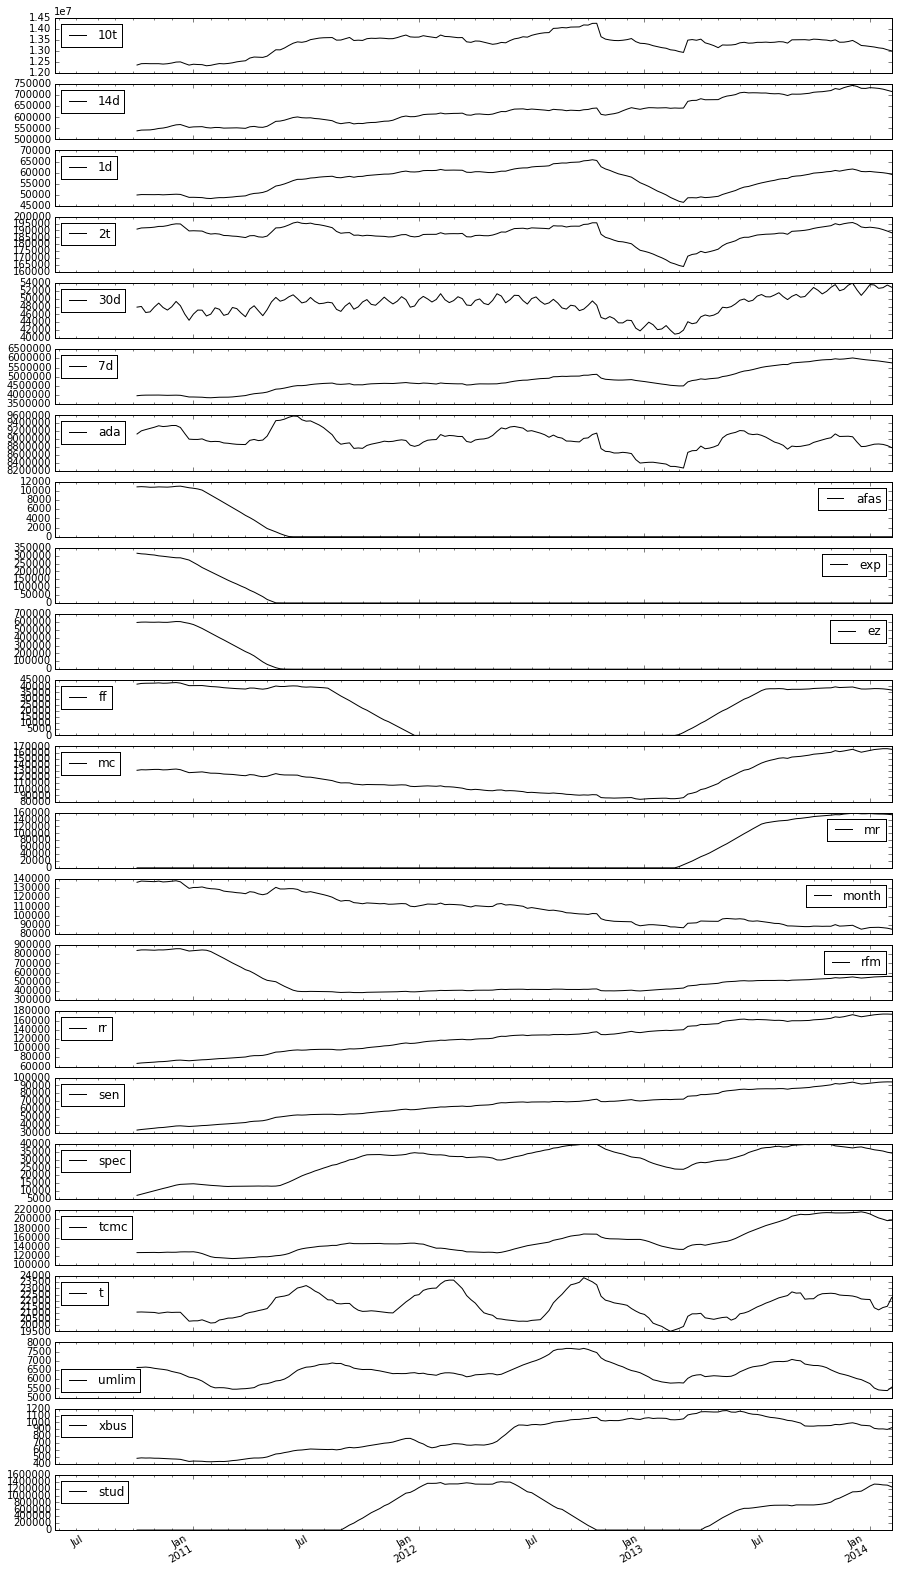

In [133]:
# Rolling mean
mta_stations = np.transpose(np.nansum(MTA, axis=0))
mta_stations = pd.DataFrame(mta_stations,index=date,columns=ridetype).dropna()
pd.rolling_mean((mta_stations),20).plot(figsize=(15,30), subplots=True)

In [132]:
# Difference in fluxes

sta = np.array(mta_stations).shape
flux = [0]*23
i=0
for s in mta_stations:
    try:
        flux[i] = mta_stations[s][184:194].mean()/ mta_stations[s][0:10].mean()
        print ("Type: ",s,". Rate: ",flux[i])
        i+=1
        
    except ZeroDivisionError:
        pass

Type:  10t . Rate:  1.02179792595
Type:  14d . Rate:  1.25206505277
Type:  1d . Rate:  1.11134513987
Type:  2t . Rate:  0.933803359956
Type:  30d . Rate:  1.03378708071
Type:  7d . Rate:  1.38974760362
Type:  ada . Rate:  0.899841341519
Type:  afas . Rate:  0.000209446968938
Type:  exp . Rate:  1.06870326904e-05
Type:  ez . Rate:  1.50195579677e-06
Type:  ff . Rate:  0.818802130171
Type:  mc . Rate:  1.213540557
Type:  mr . Rate:  24784.9310345
Type:  month . Rate:  0.578722384564
Type:  rfm . Rate:  0.649608431376
Type:  rr . Rate:  2.59295988592
Type:  sen . Rate:  2.90939676884
Type:  spec . Rate:  70.1823788546
Type:  tcmc . Rate:  1.5322710627
Type:  t . Rate:  1.02158903228
Type:  umlim . Rate:  0.809063881804
Type:  xbus . Rate:  1.66232675346


### Increase
+ Xbus: express bus
+ t: (slight)
+ tcmec: transit check metrocard
+ spec: special
+ sen: senior citizen
+ rr: rail road
+ mr: mail and ride
+ 7d: 7 day
+ 14d: 14 day

###Decline:
+ rfm: reduced fare media 
+ month: monthly
+ exp: express
+ afas: ada farecard access system
+ ez: easy pay

#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

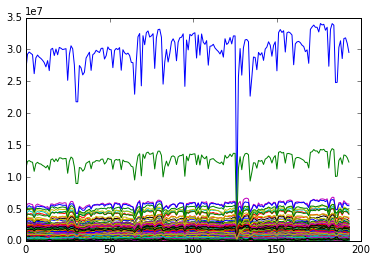

In [186]:
fou = np.abs(np.fft.rfft(mta_rides))
#will return the fourier transform, but what you want is its absolute value: np.abs(). 
#Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function
plot(fou)
#fig=pl.figure(figsize=(15,5))
#ax=fig.add_subplot(111)
#ax.plot(np.fft.rfftfreq(386, 1),(fou), ms=20) #386
#ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)

(98L,)
(98L,)


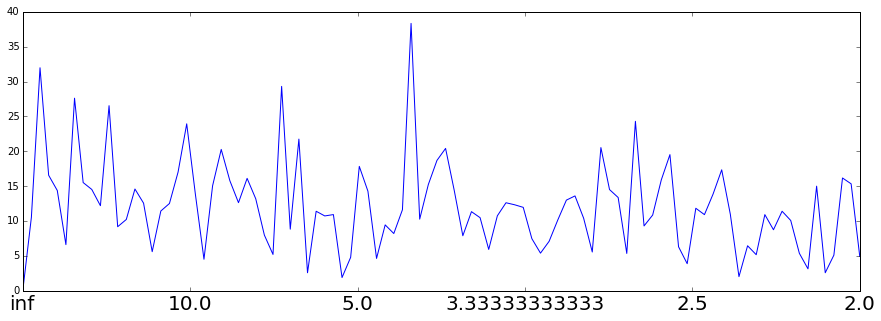

In [185]:
fou = np.abs(np.fft.rfft(mta_mean - mta_mean.mean())/mta_mean.std())
#will return the fourier transform, but what you want is its absolute value: np.abs(). 
#Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function
print(fou.shape)
print(np.fft.rfftfreq(194, 1).shape)
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(194, 1),(fou), ms=20) #386
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)

In [ ]:
f = np.abs(np.fft.rfft(sinewave))


fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(, 'o', ms=20)
#ax.plot(np.fft.rfftfreq(N, 1.0/sample_rate), (f), '-')

#ax.set_xticklabels([ "%.2f"%(f) for f in ax.get_xticks()], fontsize=20)
#pl.xlabel("frequency (1/seconds - Hz)", fontsize=20)
#pl.ylabel("Power", fontsize=20)
#pl.title("Power Spectrum", fontsize=20)

to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function: np.fft.rfft
np.fft.rfft(mydata)
will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function
np.fft.rfftfreq(N, d)
which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)



#Possibly useful functions

##I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. 
##(But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)



In [36]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [37]:
#after I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [88]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mta.shape)
mta_allsum = np.nansum(mta, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mta, axis=1)
print (mta_allsum.shape)



NameError: name 'mta' is not defined

##NOTE ON THE TREND DETECTION:
###you should find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking for something that has a more or less constant trend

###to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

###you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

###notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


###below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

##to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
##an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

In [ ]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

In [ ]:
#this is a "power spectrum": the plot of the absolute value of the fourier transform. 
#I changed the xtick labels from frequecy (1/week) to period (in weeks)
#to facilitate the visual identification of the 1-year period peak
#(notice however that np.fft.rfftfreq(N, d)  returns frequency)

In [ ]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space